In [1]:
%matplotlib inline

import argparse
from collections import defaultdict, OrderedDict
import multiprocessing as mp
import os
import pickle
import re
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

from joblib import Parallel, delayed
import numpy as np
# import ray
# # use fewer CPUs so the OS doesn't run out of processes
# ray.init(num_cpus=16)
# import modin.pandas as pd
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

log = sys.stdout

## Global, general purpose functions

In [2]:
def pickle_dump(obj, path):
    with open(path, "wb") as outfile:
        pickle.dump(obj, outfile)
       
    
def pickle_load(path):
    with open(path, "rb") as infile:
        return pickle.load(infile)
    
    
def nan_fraction(df, verbose=False, show_plots=False):
    ostream = sys.stdout if verbose else open(os.devnull, "w")
    column_wise =  df.isna().mean()
    in_total = df.isna().sum().sum() / df.size
    print("Per column:\n", column_wise, file=ostream)
    if show_plots:
        plt.title("Fraction of NaNs in column")
        sns.distplot(column_wise.values)
    print("In total: ", in_total, file=ostream)
    return column_wise, in_total

In [3]:
def extract_barcodes(df):
    barcode_list = []
    barcode_pattern = r"(^(A|C|G|T)+-1)|(.*_(ad|dp)$)"
    for colname in df.columns:
        if re.match(barcode_pattern, colname) is not None:
            barcode_list.append(colname.split("_")[0])
    return np.unique(barcode_list)


def filter_barcodes(df, keep_list):
    barcode_pattern = r"(^(A|C|G|T)+-1)|(.*_(ad|dp)$)"
    remaining_list = []
    keep_set = set(keep_list)
    for colname in df.columns:
        if re.match(barcode_pattern, colname) is None:
            remaining_list.append(colname)
        else: 
            maybe_barcode = colname.split("_")[0] 
            if maybe_barcode in keep_set:
                remaining_list.append(colname)
    # https://stackoverflow.com/questions/40636514/selecting-pandas-dataframe-column-by-list
    return df[df.columns.intersection(remaining_list)]
        

def extract_snps(df):
    return np.array([
        f"{chrom},{pos}"
        for chrom, pos in 
        tqdm_notebook(df[["CHROM", "POS"]]\
                      .to_dense()\
                      .values\
                      .astype(np.int64), 
                      desc="extracting snps...")
    ])


def extract_counts(df, suffix="dp"):
    barcode_list = extract_barcodes(df)
    return df[[f"{barcode}_{suffix}" for barcode in barcode_list]]


def assert_gene_ordering(df, genome_df):
    true_gene_ids = np.hstack(np.where(genome_df.GENE_ID == gene_id) 
                              for gene_id in tqdm_notebook(df.GENE_ID, "asserting correct gene ordering"))
    # assert correct (strictly ascending) gene ordering in gene_counts_df
    assert np.all(np.diff(true_gene_ids) > 0) 

## Loading data

### Setting up paths

In [4]:
root_data_dir = subprocess.check_output(
    "echo $MB_PROCESSED/vcf_to_ase", 
    shell=True
).decode("UTF-8").strip()
sample_data_dir = "/".join([root_data_dir, "first_sample", "scRNA"])
data_name = "scRNA"
experiment_name = "sample-1"
clustering_name = "seurat"

### Loading reference genome

In [5]:
genome_df = pd.read_csv(f"{root_data_dir}/genome.csv")
assert np.all(np.isin(["CHROM", "START", "END", "GENE_ID"], genome_df.columns))
genome_df.head()

,CHROM,START,END,GENE_NAME,GENE_ID
0,1,11869,31109,"DDX11L1,MIR1302-10,WASH7P","ENSG00000223972,ENSG00000227232,ENSG00000243485"
1,1,34554,36081,FAM138A,ENSG00000237613
2,1,52473,54936,OR4G4P,ENSG00000268020
3,1,62948,63887,OR4G11P,ENSG00000240361
4,1,69091,70008,OR4F5,ENSG00000186092


### Loading phasing information

In [6]:
phasing_df = pd.read_csv(f"{root_data_dir}/phasing.csv")
assert np.all(np.isin(["CHROM", "POS", "PHASE"], phasing_df.columns))
phasing_df.head()

,CHROM,POS,REF,ALT,PHASE
0,1,14464,A,T,1
1,1,14907,A,G,1
2,1,14976,G,A,1
3,1,15118,A,G,1
4,1,15211,T,G,1


### Loading read counts

In [8]:
%%time
if os.path.exists(f"{sample_data_dir}/raw_counts.pkl"):
    # this is much faster than reading in chunks and concatenating those
    raw_counts_df = pd.read_pickle(f"{sample_data_dir}/raw_counts.pkl")
else:
    chunksize = 2**12
    reader = pd.read_csv(f"{sample_data_dir}/raw_counts.csv", 
                         dtype=np.float64, 
                         chunksize=chunksize)
    raw_counts_df = pd.concat(
        [chunk.to_sparse() for chunk in 
         tqdm_notebook(reader, desc=f"reading counts in chunks of size {chunksize}")]
    )
    raw_counts_df.to_pickle(f"{sample_data_dir}/raw_counts.pkl")
    
raw_counts_df.head()

CPU times: user 33min 14s, sys: 1min 53s, total: 35min 7s
Wall time: 34min 4s


,CHROM,POS,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,1.0,14907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,14976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,15118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,15211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,16068.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
raw_counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 240960 entries, 0 to 240959
Columns: 13340 entries, CHROM to TTTGTCATCCCAAGAT-1_dp
dtypes: Sparse[float64, nan](13340)
memory usage: 24.2 MB


Per column:
 CHROM                    0.000000
POS                      0.000000
AAACCTGCACATCCAA-1_ad    0.999797
AAACCTGCACATCCAA-1_dp    0.999797
AAACCTGCACTAGTAC-1_ad    0.999680
                           ...   
TTTGTCAGTTAAAGAC-1_dp    0.999689
TTTGTCATCATCGGAT-1_ad    0.999427
TTTGTCATCATCGGAT-1_dp    0.999427
TTTGTCATCCCAAGAT-1_ad    0.999660
TTTGTCATCCCAAGAT-1_dp    0.999660
Length: 13340, dtype: float64
In total:  0.9993720924647238


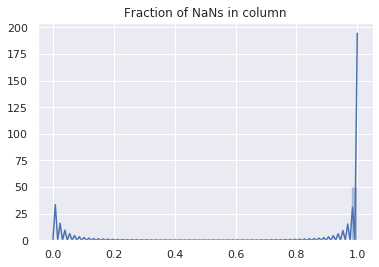

In [10]:
nan_fraction(raw_counts_df, verbose=True, show_plots=True);

## Ensuring that alternative allele is maternal (0|1 in raw phasing results)

In [11]:
%%time
phasing_df = phasing_df.merge(raw_counts_df[["CHROM", "POS"]].to_dense())
assert phasing_df.shape[0] == raw_counts_df.shape[0]

if os.path.exists(f"{sample_data_dir}/counts.pkl"):
    counts_df = pd.read_pickle(f"{sample_data_dir}/counts.pkl")
else:
    counts_df = raw_counts_df.copy()
    counts_df["PHASE"] = phasing_df.PHASE
    male_alt = counts_df.PHASE == 1
    
    for barcode in tqdm_notebook(extract_barcodes(counts_df), desc="cell_barcode"):
        ad = counts_df[f"{barcode}_ad"].to_dense()
        dp = counts_df[f"{barcode}_dp"].to_dense()
        ad[male_alt] = dp[male_alt].sub(ad[male_alt], fill_value=0)
        counts_df[f"{barcode}_ad"] = ad.to_sparse()
        
    assert nan_fraction(counts_df.drop(columns=["PHASE"]))[1] == nan_fraction(raw_counts_df)[1]
    counts_df.to_pickle(f"{sample_data_dir}/counts.pkl")


CPU times: user 7min 12s, sys: 9.14 s, total: 7min 22s
Wall time: 7min 18s


In [12]:
# ensure that non-phased SNPs were filtered out
assert np.all(np.isin(extract_snps(counts_df), 
                      extract_snps(phasing_df)))

In [13]:
counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 240960 entries, 0 to 240959
Columns: 13341 entries, CHROM to PHASE
dtypes: Sparse[float64, nan](13340), Sparse[int64, nan](1)
memory usage: 26.0 MB


In [14]:
counts_df.density

0.0007028173690566172

### Loading clustering information

In [15]:
def extract_clusters(clustering_df, entry_col="BARCODE"):
    cluster_to_entries = {}
    for label, indices in clustering_df.groupby("LABEL").groups.items():
        cluster_to_entries[label] = clustering_df[entry_col][indices].values
    return cluster_to_entries

def extract_cluster_labels(clustering_df):
    return sorted(clustering_df.LABEL.unique())

In [18]:
counts_df = pd.read_pickle(f"{sample_data_dir}/counts.pkl")
clustering_df = pd.read_csv(f"{sample_data_dir}/clustering.csv").sort_values(by="BARCODE")
clustering_df.to_csv(f"{sample_data_dir}/clustering.csv", index=False)

curr_barcodes = extract_barcodes(counts_df)
if len(curr_barcodes) != len(clustering_df["BARCODE"]) or np.any(curr_barcodes != clustering_df["BARCODE"]): 
    counts_df = filter_barcodes(counts_df, clustering_df["BARCODE"]) 
    counts_df.to_pickle(f"{sample_data_dir}/counts.pkl")
    
assert np.all(extract_barcodes(counts_df) == clustering_df["BARCODE"])

print("Cluster labels: ", extract_cluster_labels(clustering_df))
clustering_df.info()

Cluster labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6126 entries, 0 to 6125
Data columns (total 4 columns):
BARCODE    6126 non-null object
LABEL      6126 non-null int64
TSNE_1     6126 non-null float64
TSNE_2     6126 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 239.3+ KB


## Mapping SNPs to genes (and the other way around)

In [19]:
counts_df = pd.read_pickle(f"{sample_data_dir}/counts.pkl")
genome_df = pd.read_csv(f"{root_data_dir}/genome.csv")
snp_df = counts_df[["CHROM", "POS"]].to_dense().astype(np.int64)

In [20]:
def extract_genes_on_chromosome(df):
    chrom_to_genes = {}
    for chrom in genome_df["CHROM"].value_counts().keys():
        chrom_to_genes[chrom] = genome_df[genome_df.CHROM == chrom]
    return chrom_to_genes

chrom_to_genes = extract_genes_on_chromosome(genome_df)

In [21]:
%%time

# Here gene coverage for each phased SNP is computed
# TODO: rewrite this using "bedtools intersect".
# This part doesn't scale well.

def map_snp_to_genes(snp_tuple):
    chrom, pos = snp_tuple
    # 1-based to 0-based 
    pos -= 1 # because CellCNP is 1-based, but .bed files are 0-based
    genes_on_chrom = chrom_to_genes[str(chrom)]
    mask = (genes_on_chrom.START <= pos) & (pos < genes_on_chrom.END)
    return ';'.join(genes_on_chrom[mask].GENE_ID)

pool = mp.Pool(16)
result = pool.map(map_snp_to_genes, 
                  tqdm_notebook(snp_df.values, "SNP processing"))
pool.close()
pool.join()

CPU times: user 3.64 s, sys: 5.17 s, total: 8.8 s
Wall time: 42.5 s


In [22]:
genome_df.head()

,CHROM,START,END,GENE_NAME,GENE_ID
0,1,11869,31109,"DDX11L1,MIR1302-10,WASH7P","ENSG00000223972,ENSG00000227232,ENSG00000243485"
1,1,34554,36081,FAM138A,ENSG00000237613
2,1,52473,54936,OR4G4P,ENSG00000268020
3,1,62948,63887,OR4G11P,ENSG00000240361
4,1,69091,70008,OR4F5,ENSG00000186092


In [23]:
""" Here the raw results computed in parallel are parsed """

snp_to_genes, gene_to_snps = {}, OrderedDict()

# This way we ensure proper gene ordering
for gene_id in genome_df.GENE_ID:
    gene_to_snps[gene_id] = []

for i, row in tqdm_notebook(enumerate(snp_df.values), "mapping SNPs to genes"):
    chrom, pos = row
    snp = f"{chrom},{pos}"
    snp_to_genes[snp] = result[i].split(";") if result[i] else []
    for gene in snp_to_genes[snp]:
        gene_to_snps[gene].append(snp)

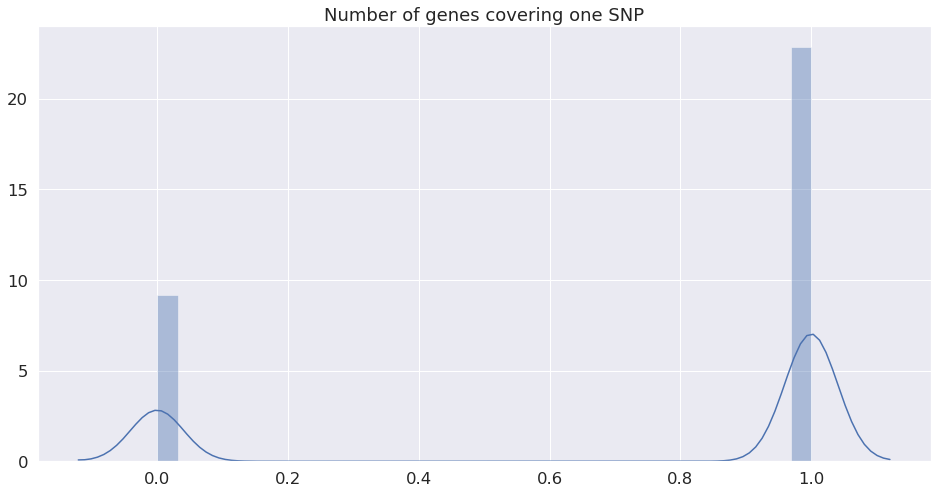

In [24]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.title("Number of genes covering one SNP")
sns.distplot([len(gene_list) for gene_list in snp_to_genes.values()]);

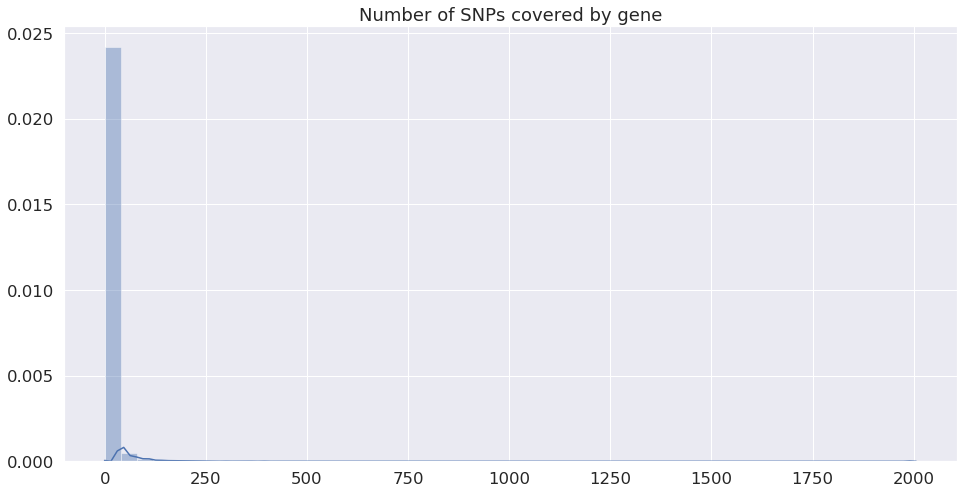

In [25]:
plt.figure(figsize=(16,8))
plt.title("Number of SNPs covered by gene")
sns.distplot([len(snp_list) for snp_list in gene_to_snps.values()]);

In [26]:
pickle_dump(snp_to_genes, f"{sample_data_dir}/snp_to_genes.pkl")
pickle_dump(gene_to_snps, f"{sample_data_dir}/gene_to_snps.pkl")

## Aggregating read counts over genes

In [27]:
gene_to_snps = pickle_load(f"{sample_data_dir}/gene_to_snps.pkl")
snp_to_genes = pickle_load(f"{sample_data_dir}/snp_to_genes.pkl")
gene_counts_df = pd.SparseDataFrame()

In [28]:
snp_to_idx = {snp : i for i, snp in 
              tqdm_notebook(enumerate(extract_snps(counts_df)), 
                            "mapping snps to their index numbers by position in the genome")}

Per column:
 AAACCTGCACATCCAA-1_ad    0.999797
AAACCTGCACATCCAA-1_dp    0.999797
AAACCTGCACTAGTAC-1_ad    0.999680
AAACCTGCACTAGTAC-1_dp    0.999680
AAACCTGCATCATCCC-1_ad    0.999830
                           ...   
TTTGTCAGTTAAAGAC-1_dp    0.999689
TTTGTCATCATCGGAT-1_ad    0.999427
TTTGTCATCATCGGAT-1_dp    0.999427
TTTGTCATCCCAAGAT-1_ad    0.999660
TTTGTCATCCCAAGAT-1_dp    0.999660
Length: 12252, dtype: float64
In total:  0.9996002292386662


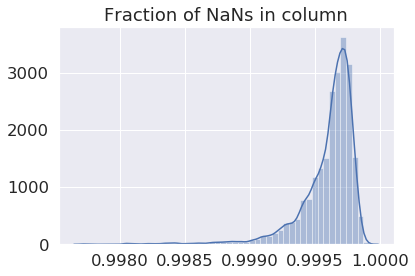

In [29]:
nan_fraction(counts_df.drop(columns=["CHROM", "POS", "PHASE"]), 
             verbose=True, show_plots=True);

In [30]:
%%time

gene_to_snp_ids = {gene : np.array([snp_to_idx[snp] for snp in snp_list]) 
                   for gene, snp_list in tqdm_notebook(gene_to_snps.items(), 
                                                       desc="mapping gene to SNP ids (for faster row selection)")}

def extract_gene_counts(barcode):
    gene_to_ad, gene_to_dp = [], []
    # I need to convert these columns to dense format
    # because I need only a subset of rows on each iteration 
    ad = counts_df[f"{barcode}_ad"].to_dense().values
    dp = counts_df[f"{barcode}_dp"].to_dense().values
    # gene_to_snps is an OrderedDict, so we can guarantee
    # that all the genes are processed in a correct order
    for gene, snp_ids in gene_to_snp_ids.items():
        if len(snp_ids) > 0:
            ad_sample, dp_sample = ad[snp_ids], dp[snp_ids]
            gene_to_ad.append(np.nan if np.all(np.isnan(ad_sample)) else np.nansum(ad_sample))
            gene_to_dp.append(np.nan if np.all(np.isnan(dp_sample)) else np.nansum(dp_sample))
    return pd.DataFrame({f"{barcode}_ad" : gene_to_ad, 
                         f"{barcode}_dp" : gene_to_dp})

with mp.Pool(16) as pool:
    result_list = pool.map(
        extract_gene_counts, 
        tqdm_notebook(extract_barcodes(counts_df), 
                      desc="cell_barcode processing")
    )
# result_list = [extract_gene_counts(barcode) for barcode in tqdm_notebook(extract_barcodes(counts_df))]    
gene_counts_df = pd.concat(result_list, axis=1).to_dense()
gene_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Columns: 12252 entries, AAACCTGCACATCCAA-1_ad to TTTGTCATCCCAAGAT-1_dp
dtypes: float64(12252)
memory usage: 955.7 MB
CPU times: user 6.5 s, sys: 18.6 s, total: 25.1 s
Wall time: 1min 52s


Per column:
 AAACCTGCACATCCAA-1_ad    0.997164
AAACCTGCACATCCAA-1_dp    0.997164
AAACCTGCACTAGTAC-1_ad    0.995990
AAACCTGCACTAGTAC-1_dp    0.995990
AAACCTGCATCATCCC-1_ad    0.997457
                           ...   
TTTGTCAGTTAAAGAC-1_dp    0.995794
TTTGTCATCATCGGAT-1_ad    0.991686
TTTGTCATCATCGGAT-1_dp    0.991686
TTTGTCATCCCAAGAT-1_ad    0.995012
TTTGTCATCCCAAGAT-1_dp    0.995012
Length: 12252, dtype: float64
In total:  0.9947778958000917


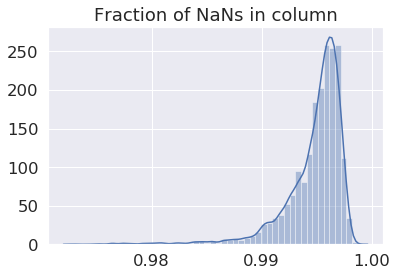

In [31]:
nan_fraction(gene_counts_df, verbose=True, show_plots=True);

In [32]:
gene_counts_df.insert(0, "GENE_ID", [gene for gene, snp_list 
                                     in gene_to_snps.items() 
                                     if len(snp_list) > 0])
assert_gene_ordering(gene_counts_df, genome_df)
gene_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCTCCG-1_ad,AAACCTGGTAGCTCCG-1_dp,AAACCTGGTCTAAACC-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,"ENSG00000223972,ENSG00000227232,ENSG00000243485",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"ENSG00000233750,ENSG00000238009,ENSG00000239945",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000239906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"ENSG00000228463,ENSG00000241670",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"ENSG00000185097,ENSG00000198744,ENSG0000022365...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
gene_counts_df.to_pickle(f"{sample_data_dir}/gene_counts.pkl")

## Summarizing the dataset (for QC purposes)

In [34]:
# This function is really, REALLY inefficient. It implicitly converts counts_df to dense,
# which is absolutely unacceptable given the size of that dataframe.
# I have to find a way to compute the same statistics better.

def describe_raw_counts(counts_df, desc, clustering_df=None, feature_name="SNP"):
    """
    @counts_df — pd.SparseDataframe — raw counts
    @desc — description of counts_df
    @clustering_df — pd.DataFrame — assigns cluster label to each barcode
    
    This function summarizes the information about the raw counts.
    It computes such summary statistics as:
        1. Fraction of NaNs (per barcode)
        2. Average number of reads mapped to SNP (per barcode)
        3. Total number of reads (per barcode)
        4. Number of SNPs with at least one mapped read (per barcode). 
    If clustering information is provided, it also computes the distribution
    of reads across genome, taking cluster structure into account. 
    To do so, it adds up the reads mapping to each SNP (individually) for each 
    barcode in the cluster and then divides the sum by the cluster size.
    """
    
    print("{} columns, {} barcodes, {} {}s".format(
        counts_df.shape[1],
        len(extract_barcodes(counts_df)),
        counts_df.shape[0],
        feature_name
    ))

    fig, axes = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)
    fig.suptitle(desc)
    axes[0,0].set_title("Fraction of NaNs per cell");
    counts_df.isna().mean().hist(ax=axes[0,0]);

    axes[0,1].set_title(f"Reads per {feature_name} (on average) per cell");
    extract_counts(counts_df, suffix="dp").mean().hist(ax=axes[0,1]);

    axes[1,0].set_title("Reads per barcode (in total)");
    extract_counts(counts_df, suffix="dp").sum().hist(ax=axes[1,0]);

    axes[1,1].set_title(f"{feature_name}s with at least one mapped read (one point per cell)");
    (extract_counts(counts_df, suffix="dp") > 0).sum().hist(ax=axes[1,1]);
    fig.show()

    if clustering_df is not None:
        cluster_to_barcodes = extract_clusters(clustering_df)
        cluster_label_list = extract_cluster_labels(clustering_df)
        print("Cluster labels: ", cluster_label_list)

        n_clusters = len(cluster_label_list)
        grid_shape = (n_clusters // 2 + n_clusters % 2, 2)
        sns.set()
        fig, axes = plt.subplots(*grid_shape, figsize=(15, 2 * n_clusters), constrained_layout=True)
        fig.suptitle("Distribution of reads in the genome (per cluster, DP counts averaged within cluster)")
        for i, label in enumerate(tqdm_notebook(cluster_label_list, desc="processing clusters")):
            ax = axes[i // grid_shape[1], i % grid_shape[1]]
            ax.set_title(f"Cluster label: {label}")
            ax.set_xlabel(f"{feature_name} id")
            ax.set_ylabel("mean DP count")    
            dp_counts = np.zeros(counts_df.shape[0])
            for barcode in cluster_to_barcodes[label]:
                dp_counts = dp_counts + counts_df[f"{barcode}_dp"].to_dense().fillna(0).values
            dp_counts /= len(cluster_to_barcodes[label])
            ax.plot(dp_counts, label=label)
        fig.show()

In [35]:
# %%time
# describe_raw_counts(counts_df, "scRNA, sample-1", clustering_df)

12253 columns, 6126 barcodes, 10224 genes


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Cluster labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


CPU times: user 11.7 s, sys: 2.92 s, total: 14.7 s
Wall time: 16 s


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


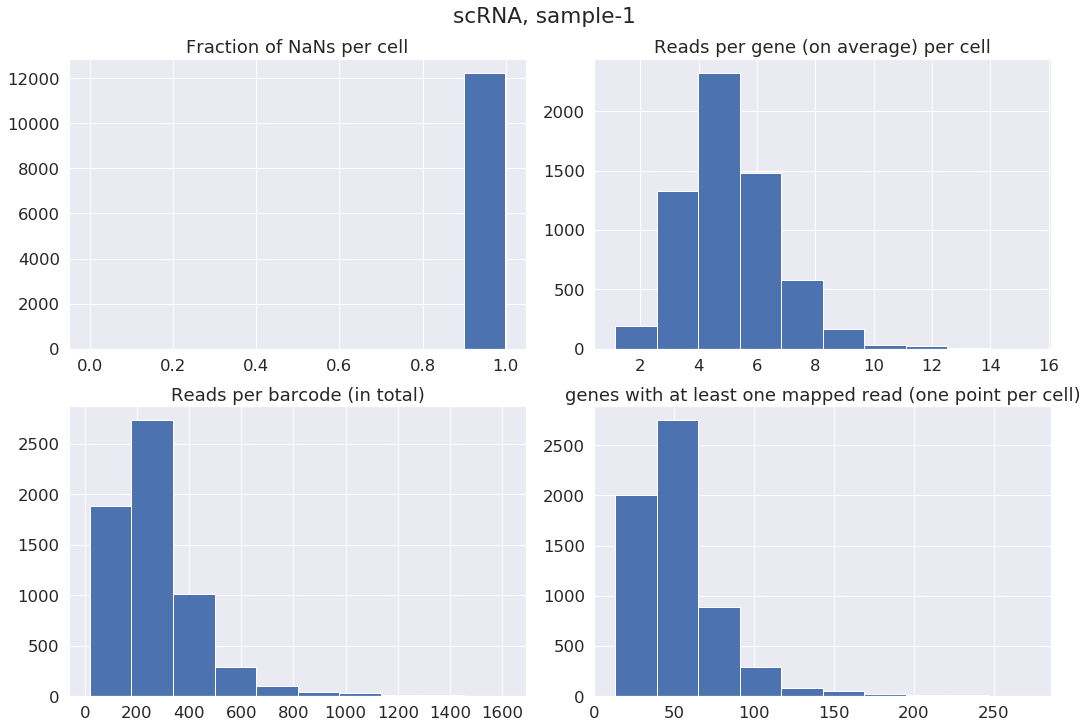

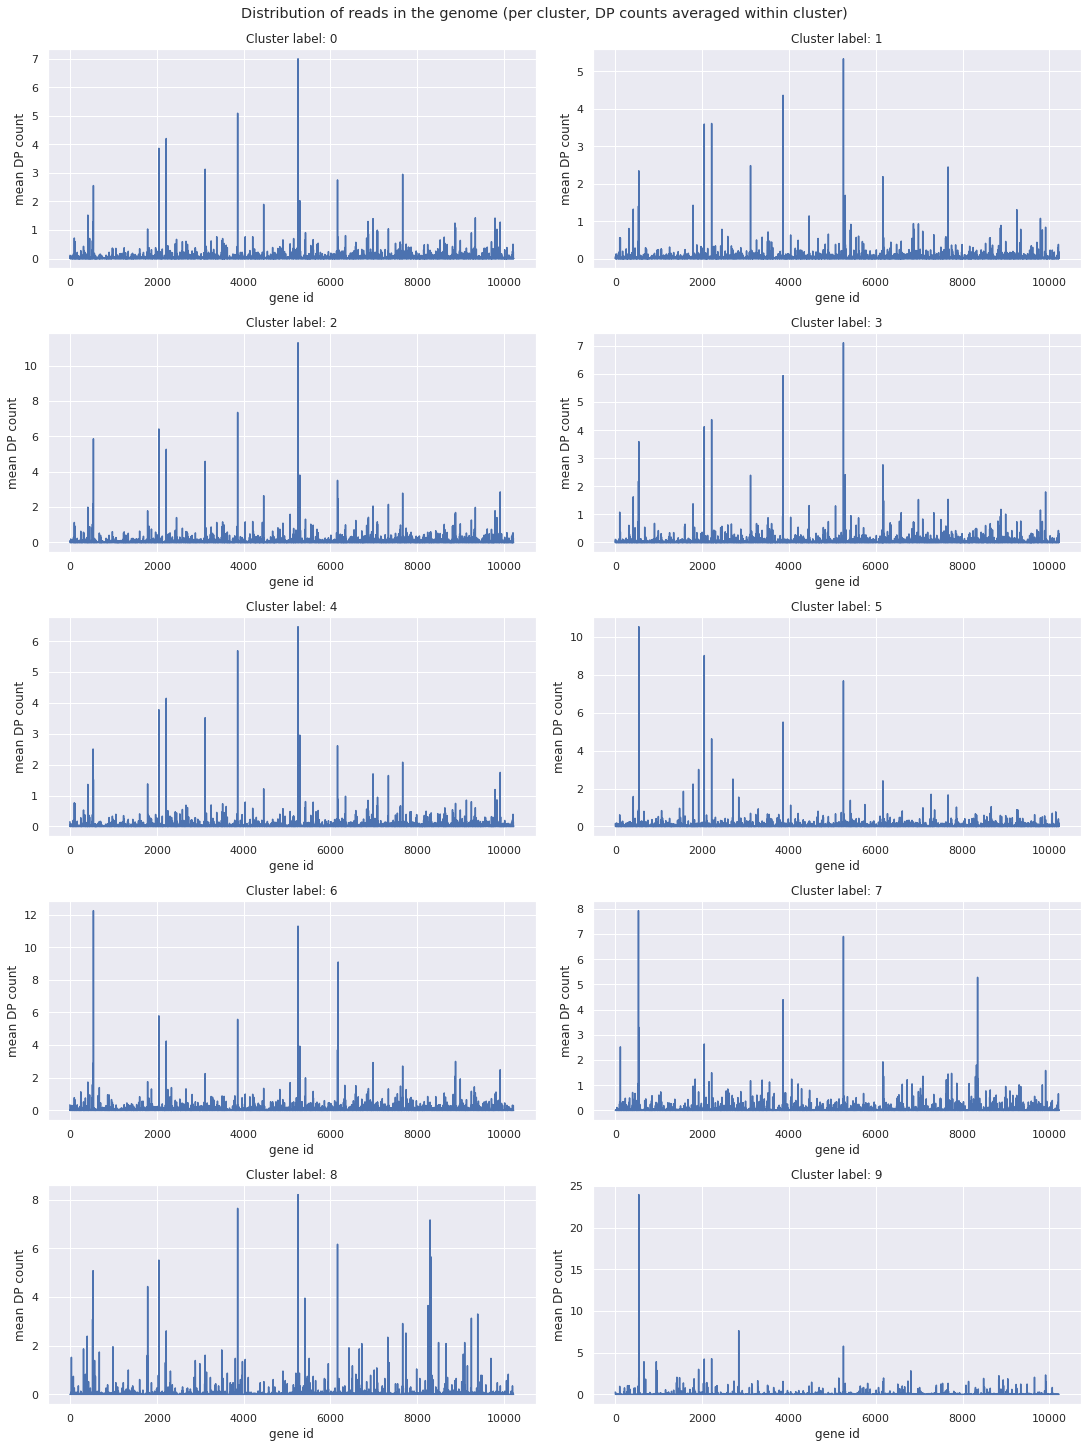

In [36]:
%%time
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
describe_raw_counts(gene_counts_df, 
                    f"{data_name}, {experiment_name}", 
                    clustering_df, 
                    feature_name="gene")

## Getting an ASE matrix

In [37]:
def compute_ase(counts_df, barcode_list):
    ase_df = pd.concat([
        pd.DataFrame({
            f"{barcode}" 
            : counts_df[f"{barcode}_ad"].to_dense().fillna(0) 
            / counts_df[f"{barcode}_dp"].to_dense().fillna(0)
        }) 
        for barcode in tqdm_notebook(barcode_list, desc="ase from read counts")], 
        axis=1
    )
    return ase_df

In [38]:
def plot_ase(ase_df, title="", figsize=(10,10), **clustermap_kwargs):
    try: 
        sns.clustermap(
            ase_df\
            .fillna(value=0.5)\
            .astype(np.float32)\
            .values,
            cmap="viridis",
            figsize=figsize,
            row_cluster=False,
            xticklabels=[colname for colname in ase_df.columns 
                         if colname != "GENE_ID"], 
            **clustermap_kwargs
        ).fig.suptitle(title);
    except RecursionError:
        print("RecursionError: increase stack size")

In [39]:
%%time
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
ase_df = compute_ase(gene_counts_df, extract_barcodes(gene_counts_df))
ase_df.to_pickle(f"{sample_data_dir}/ase.pkl")
ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Columns: 6126 entries, AAACCTGCACATCCAA-1 to TTTGTCATCCCAAGAT-1
dtypes: float64(6126)
memory usage: 477.8 MB
CPU times: user 13.9 s, sys: 4.18 s, total: 18.1 s
Wall time: 18.9 s


Per column:
 AAACCTGCACATCCAA-1    0.997164
AAACCTGCACTAGTAC-1    0.996088
AAACCTGCATCATCCC-1    0.997555
AAACCTGGTAGCTCCG-1    0.995794
AAACCTGGTCTAAACC-1    0.994914
                        ...   
TTTGTCAGTGCGCTTG-1    0.989241
TTTGTCAGTGTTTGTG-1    0.993642
TTTGTCAGTTAAAGAC-1    0.995794
TTTGTCATCATCGGAT-1    0.991784
TTTGTCATCCCAAGAT-1    0.995012
Length: 6126, dtype: float64
In total:  0.9948370985516976


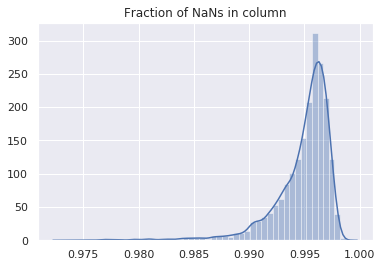

In [40]:
nan_fraction(ase_df, verbose=True, show_plots=True);

## Aggregating by cell barcode (by groups of columns)

Take read counts and clustering info as an input.
Add up the counts in each cluster. 

In [41]:
""" TODO: check for bugs """
def aggregate_by_barcode_groups(counts_df, clustering_df):
    assert np.all(np.isin(clustering_df.BARCODE, 
                          extract_barcodes(counts_df)))
    
    cluster_to_barcodes = extract_clusters(clustering_df)
    cluster_labels = extract_cluster_labels(clustering_df)
    
    result_df = pd.DataFrame()
    
    for label in tqdm_notebook(cluster_labels, desc="cluster label"):
        for suffix in ["ad", "dp"]:
            result_df[f"{label}_{suffix}"] = np.zeros(counts_df.shape[0])    
            na_mask = np.full(counts_df.shape[0], True)
            for barcode in cluster_to_barcodes[label]:
                counts = counts_df[f"{barcode}_{suffix}"].to_dense().values
                na_mask = na_mask & np.isnan(counts)
                result_df[f"{label}_{suffix}"] += np.nan_to_num(counts)
            result_df[f"{label}_{suffix}"][na_mask] = np.nan
    return result_df

In [42]:
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
clustered_df = aggregate_by_barcode_groups(gene_counts_df, clustering_df)
clustered_df.to_pickle(f"{sample_data_dir}/clustered_gene_counts.pkl")
clustered_df.head()

,0_ad,0_dp,1_ad,1_dp,2_ad,2_dp,3_ad,3_dp,4_ad,4_dp,5_ad,5_dp,6_ad,6_dp,7_ad,7_dp,8_ad,8_dp,9_ad,9_dp
0,164.0,183.0,41.0,61.0,77.0,107.0,59.0,88.0,88.0,102.0,20.0,39.0,52.0,52.0,NaN,NaN,NaN,NaN,0.0,6.0
1,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,0.0,4.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,3.0,5.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,3.0,6.0,1.0,2.0,2.0,7.0,1.0,1.0,0.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


20 columns, 10 barcodes, 10224 genes


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


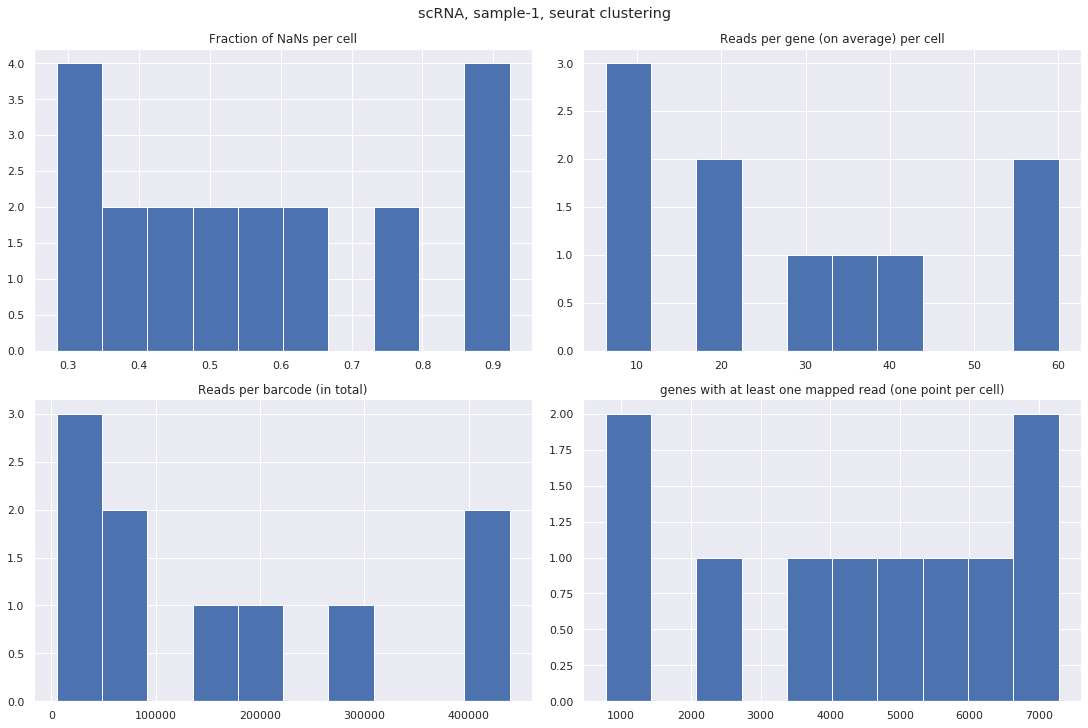

In [43]:
describe_raw_counts(clustered_df, 
                    f"{data_name}, {experiment_name}, {clustering_name} clustering", 
                    feature_name="gene")

In [44]:
# clustered_ase_df = pd.read_pickle(f"{sample_data_dir}/clustered_ase_df.pkl")
clustered_ase_df = compute_ase(clustered_df, extract_cluster_labels(clustering_df))
clustered_ase_df.to_pickle(f"{sample_data_dir}/clustered_ase.pkl")
clustered_ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Data columns (total 10 columns):
0    7279 non-null float64
1    6363 non-null float64
2    7239 non-null float64
3    5851 non-null float64
4    5274 non-null float64
5    4226 non-null float64
6    3730 non-null float64
7    2144 non-null float64
8    929 non-null float64
9    776 non-null float64
dtypes: float64(10)
memory usage: 798.9 KB


In [45]:
clustered_ase_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.896175,0.672131,0.719626,0.670455,0.862745,0.512821,1.0,NaN,NaN,0.0
1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.600000,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.000000,0.500000,0.500000,0.285714,1.000000,0.000000,0.5,NaN,NaN,NaN


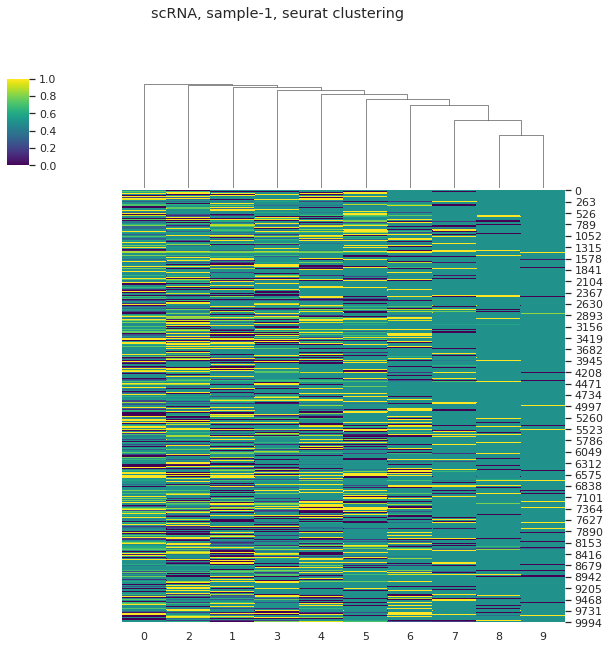

In [57]:
sys.setrecursionlimit(15000)
plot_ase(clustered_ase_df,
         f"{data_name}, {experiment_name}, {clustering_name} clustering")

## Aggregating by genes (by groups of rows)

This one is tricky because row operations seem to be very inefficient in pd.SparseDataFrame.  
But I still can process the barcode columns individually (or in batches). This is fast enough to be useful

In [47]:
def select_by_score(gene_counts_df, scoring_df, smaller_is_better=True, n_out=1000):
    assert np.all(np.isin(["SCORE", "GENE_ID"], scoring_df.columns))
    
    result_df = gene_counts_df.to_dense().merge(scoring_df[["SCORE", "GENE_ID"]])
    result_df.sort_values(by="SCORE", ascending=smaller_is_better, inplace=True)
    result_df = result_df.iloc[:n_out, :]
    result_df.sort_index(inplace=True)
    result_df.drop(columns=["SCORE"], inplace=True)
    return result_df

#### Giving it a try: selecting top 1000 genes by PCA loading scores

In [48]:
scoring_df = pd.read_csv(f"{root_data_dir}/first_sample/scores.csv")
scoring_df["LS1"] = scoring_df.PC1.abs()
scoring_df["LS2"] = scoring_df.PC2.abs()
scoring_df.head()

,GENE_ID,1,2,3,PC1,PC2,LS1,LS2
0,ENSG00000000003,1.0,1.0,2.0,0.002593,-0.003106,0.002593,0.003106
1,ENSG00000000005,1.0,1.0,2.0,0.002550,-0.003145,0.002550,0.003145
2,"ENSG00000000419,ENSG00000101126,ENSG0000022866...",2.0,2.0,4.0,0.005235,0.002535,0.005235,0.002535
3,"ENSG00000000457,ENSG00000000460,ENSG0000000790...",2.0,2.0,4.0,0.005780,0.001431,0.005780,0.001431
4,ENSG00000000938,2.0,2.0,4.0,0.005479,0.000884,0.005479,0.000884


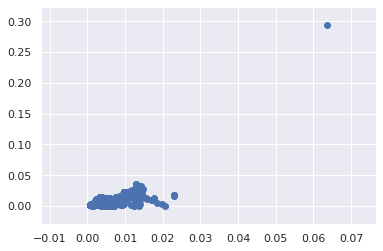

In [49]:
plt.scatter(scoring_df.LS1, scoring_df.LS2)

In [50]:
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
gene_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCTCCG-1_ad,AAACCTGGTAGCTCCG-1_dp,AAACCTGGTCTAAACC-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,"ENSG00000223972,ENSG00000227232,ENSG00000243485",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"ENSG00000233750,ENSG00000238009,ENSG00000239945",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000239906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"ENSG00000228463,ENSG00000241670",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"ENSG00000185097,ENSG00000198744,ENSG0000022365...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
%%time

top_genes = np.intersect1d(
    scoring_df.sort_values(by="LS1", ascending=False).GENE_ID[:1000],
    scoring_df.sort_values(by="LS2", ascending=False).GENE_ID[:1000]
)
print(len(top_genes))

639
CPU times: user 28.2 ms, sys: 5.02 ms, total: 33.2 ms
Wall time: 29 ms


In [52]:
# top_1k_gene_counts_df = select_by_score(
#     gene_counts_df, 
#     scoring_df.rename(columns={"PC1" : "SCORE"}), 
#     smaller_is_better=False, 
#     n_out=1000
# )
top_gene_counts_df = gene_counts_df[gene_counts_df.GENE_ID.isin(top_genes)]
top_gene_counts_df.to_pickle(f"{sample_data_dir}/1kPC1_^_1kPC2_gene_counts.pkl")
top_gene_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 1501 to 9818
Columns: 12253 entries, GENE_ID to TTTGTCATCCCAAGAT-1_dp
dtypes: float64(12252), object(1)
memory usage: 19.9+ MB


In [53]:
top_gene_counts_df.shape

(213, 12253)

In [54]:
top_clustered_gene_counts_df = aggregate_by_barcode_groups(
    top_gene_counts_df, 
    clustering_df
)
top_clustered_gene_counts_df.head()

,0_ad,0_dp,1_ad,1_dp,2_ad,2_dp,3_ad,3_dp,4_ad,4_dp,5_ad,5_dp,6_ad,6_dp,7_ad,7_dp,8_ad,8_dp,9_ad,9_dp
0,46.0,50.0,112.0,115.0,8.0,13.0,12.0,54.0,4.0,6.0,1.0,1.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
1,3.0,9.0,2.0,34.0,2.0,9.0,0.0,5.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,134.0,286.0,25.0,152.0,79.0,247.0,29.0,40.0,15.0,17.0,21.0,50.0,17.0,61.0,0.0,2.0,NaN,NaN,NaN,NaN
3,1.0,2.0,19.0,19.0,0.0,5.0,NaN,NaN,9.0,9.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,1.0,2.0,12.0,NaN,NaN,2.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
top_ase_df = compute_ase(
    top_clustered_gene_counts_df, 
    extract_cluster_labels(clustering_df)
)
top_ase_df.to_pickle(f"{sample_data_dir}/1kPC1_^_1kPC2_clustered_ase.pkl")

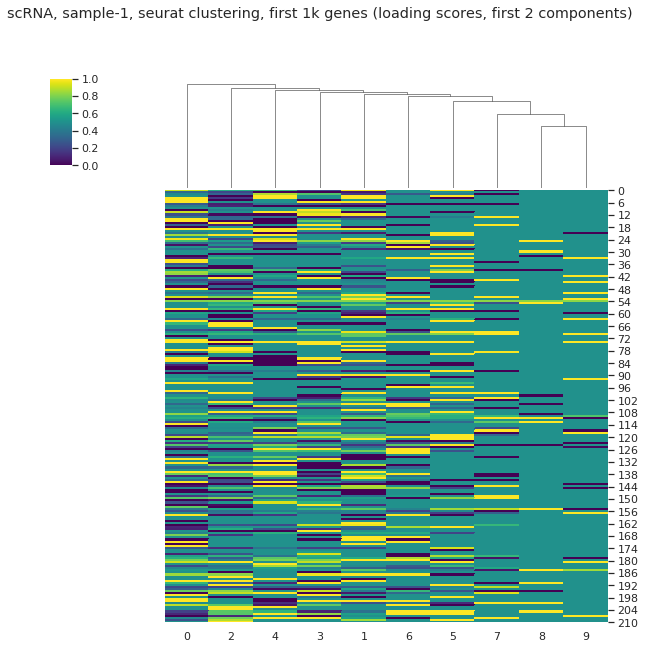

In [56]:
plot_ase(
    top_ase_df,
    f"{data_name}, {experiment_name}, {clustering_name} clustering, first 1k genes (loading scores, first 2 components)"
)